In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "20"  # 设置 OpenMP 线程数
os.environ["MKL_NUM_THREADS"] = "20"  # 设置 MKL 线程数
os.environ["NUMEXPR_NUM_THREADS"] = "20"  # 设置 NumExpr 线程数
os.environ["VECLIB_MAXIMUM_THREADS"] = "20"  # 设置 veclib 最大线程数
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import time, psutil, hydra, torch
torch.set_num_threads(20)
from hydra.utils import to_absolute_path
from omegaconf import DictConfig, OmegaConf
from torch.nn.parallel import DistributedDataParallel
from torch.utils.tensorboard import SummaryWriter
from modulus import Module
from modulus.models.diffusion import UNet, EDMPrecondSR
from modulus.distributed import DistributedManager
from modulus.metrics.diffusion import RegressionLoss, ResLoss
from modulus.launch.logging import PythonLogger, RankZeroLoggingWrapper
from modulus.launch.utils import load_checkpoint, save_checkpoint
from datasets.dataset import init_train_valid_datasets_from_config
from helpers.train_helpers import (
    set_patch_shape,
    set_seed,
    configure_cuda_for_consistent_precision,
    compute_num_accumulation_rounds,
    handle_and_clip_gradients,
    is_time_for_periodic_task,
)
import warnings
warnings.filterwarnings("ignore")


In [2]:
from omegaconf import OmegaConf
import hydra
from hydra import initialize, compose

## 解析配置文件
with initialize(config_path='conf',version_base= '1.2'):    
    mainconf = compose(config_name = 'config_training_regression')
    confkey = list(mainconf.keys())
print('============CorrDiff Downscale Conf============')
print(f"Conf list: {confkey}")
for confn in confkey:
    print(f"\nConf Para --> {confn}")
    print(f"<<{mainconf[confn]}>>")

============CorrDiff Downscale Conf============
Conf list: ['dataset', 'model', 'training', 'validation']

Conf Para --> dataset
<<{'type': 'cwb', 'data_path': '/code/2023-01-24-cwb-4years.zarr', 'in_channels': [0, 1, 2, 3, 4, 9, 10, 11, 12, 17, 18, 19], 'out_channels': [0, 17, 18, 19], 'img_shape_x': 448, 'img_shape_y': 448, 'add_grid': True, 'ds_factor': 4, 'min_path': None, 'max_path': None, 'global_means_path': None, 'global_stds_path': None}>>

Conf Para --> model
<<{'name': 'regression', 'hr_mean_conditioning': False}>>

Conf Para --> training
<<{'hp': {'training_duration': 200000000, 'total_batch_size': 256, 'batch_size_per_gpu': 2, 'lr': 0.0002, 'grad_clip_threshold': None, 'lr_decay': 1, 'lr_rampup': 10000000}, 'perf': {'fp_optimizations': 'fp32', 'dataloader_workers': 2, 'songunet_checkpoint_level': 0}, 'io': {'print_progress_freq': 1000, 'save_checkpoint_freq': 5000, 'validation_freq': 5000, 'validation_steps': 10}}>>

Conf Para --> validation
<<{'train': False, 'all_times':

In [3]:
cfg = mainconf
dataset_cfg = OmegaConf.to_container(cfg.dataset)

In [4]:
##
cfg.dataset.data_path = '/home/sprixin/test/zhangmy/cwa_dataset/cwa_dataset.zarr'
cfg.dataset.out_channels = [0,1,2,3]
cfg.training.hp.batch_size_per_gpu = 1
### downsample data size
def datacrop(data,size):
    start = data.shape[2]//2 - size//2
    return data[:, :, start:start + size, start:start + size]
###

##

In [5]:
 # Initialize distributed environment for training
DistributedManager.initialize()
dist = DistributedManager()

# Initialize loggers
if dist.rank == 0:
    writer = SummaryWriter(log_dir="tensorboard")
logger = PythonLogger("main")  # General python logger
logger0 = RankZeroLoggingWrapper(logger, dist)  # Rank 0 logger

# Resolve and parse configs
OmegaConf.resolve(cfg)
dataset_cfg = OmegaConf.to_container(cfg.dataset)  # TODO needs better handling
if hasattr(cfg, "validation_dataset"):
    validation_dataset_cfg = OmegaConf.to_container(cfg.validation_dataset)
else:
    validation_dataset_cfg = None
fp_optimizations = cfg.training.perf.fp_optimizations
fp16 = fp_optimizations == "fp16"
enable_amp = fp_optimizations.startswith("amp")
amp_dtype = torch.float16 if (fp_optimizations == "amp-fp16") else torch.bfloat16
logger.info(f"Saving the outputs in {os.getcwd()}")

# Set seeds and configure CUDA and cuDNN settings to ensure consistent precision
set_seed(dist.rank)
configure_cuda_for_consistent_precision()

# Instantiate the dataset
data_loader_kwargs = {
    "pin_memory": True,
    "num_workers": cfg.training.perf.dataloader_workers,
    "prefetch_factor": 2,
}

In [6]:
(
    dataset,
    dataset_iterator,
    validation_dataset,
    validation_dataset_iterator,
) = init_train_valid_datasets_from_config(
    dataset_cfg,
    data_loader_kwargs,
    batch_size=cfg.training.hp.batch_size_per_gpu,
    seed=0,
    validation_dataset_cfg=validation_dataset_cfg,
)

In [11]:
 # Parse image configuration & update model args
dataset_channels = len(dataset.input_channels())
img_in_channels = dataset_channels
img_shape = dataset.image_shape()
img_out_channels = len(dataset.output_channels())
# if cfg.model.hr_mean_conditioning:
#     img_in_channels += img_out_channels

In [12]:
# Parse the patch shape
if cfg.model.name == "patched_diffusion":
    patch_shape_x = cfg.training.hp.patch_shape_x
    patch_shape_y = cfg.training.hp.patch_shape_y
else:
    patch_shape_x = None
    patch_shape_y = None
patch_shape = (patch_shape_y, patch_shape_x)
img_shape, patch_shape = set_patch_shape(img_shape, patch_shape)
if patch_shape != img_shape:
    logger0.info("Patch-based training enabled")
else:
    logger0.info("Patch-based training disabled")
# interpolate global channel if patch-based model is used
if img_shape[1] != patch_shape[1]:
    img_in_channels += dataset_channels

[17:49:47 - main - INFO] Patch-based training disabled


In [13]:
if cfg.model.name not in ("regression", "diffusion", "patched_diffusion"):
    raise ValueError("Invalid model")
model_args = {  # default parameters for all networks
    "img_out_channels": img_out_channels,
    # "img_resolution": list(img_shape),
    "img_resolution": img_shape[0],
    "use_fp16": fp16,
}
standard_model_cfgs = {  # default parameters for different network types
    "regression": {
        "img_channels": 4,
        "N_grid_channels": 4,
        "embedding_type": "zero",
    },
    "diffusion": {
        "img_channels": img_out_channels,
        "gridtype": "sinusoidal",
        "N_grid_channels": 4,
    },
    "patched_diffusion": {
        "img_channels": img_out_channels,
        "gridtype": "learnable",
        "N_grid_channels": 100,
    },
}

In [14]:
model_args.update(standard_model_cfgs[cfg.model.name])
if hasattr(cfg.model, "model_args"):  # override defaults from config file
    model_args.update(OmegaConf.to_container(cfg.model.model_args))
model_args_para = model_args.copy()
N_grid_channels = model_args_para.pop('N_grid_channels')
if cfg.model.name == "regression":
    embedding_type = model_args_para.pop('embedding_type')
else:
    gridtype = model_args_para.pop('gridtype')

## resample

In [15]:
###
cropsize = 64
model_args_para['img_resolution'] = cropsize 
###

In [16]:
if cfg.model.name == "regression":
    model = UNet(
        img_in_channels=img_in_channels,# + model_args["N_grid_channels"],
        **model_args_para,
    )
else:  # diffusion or patched diffusion
    model = EDMPrecondSR(
        img_in_channels=img_in_channels,# + model_args["N_grid_channels"],
        **model_args_para,
    )
model.train().requires_grad_(True).to(dist.device)

UNet(
  (model): DhariwalUNet(
    (map_noise): PositionalEmbedding()
    (map_layer0): Linear()
    (map_layer1): Linear()
    (enc): ModuleDict(
      (64x64_conv): Conv2d()
      (64x64_block0): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (64x64_block1): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (64x64_block2): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (32x32_down): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
        (skip): Conv2d()
      )
      (32x32_block0): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
 

In [17]:
# Enable distributed data parallel if applicable
if dist.world_size > 1:
    model = DistributedDataParallel(
        model,
        device_ids=[dist.local_rank],
        broadcast_buffers=True,
        output_device=dist.device,
        find_unused_parameters=dist.find_unused_parameters,
    )

In [18]:
# Load the regression checkpoint if applicable
if hasattr(cfg.training.io, "regression_checkpoint_path"):
    regression_checkpoint_path = to_absolute_path(
        cfg.training.io.regression_checkpoint_path
    )
    if not os.path.exists(regression_checkpoint_path):
        raise FileNotFoundError(
            f"Expected a this regression checkpoint but not found: {regression_checkpoint_path}"
        )
    regression_net = Module.from_checkpoint(regression_checkpoint_path)
    regression_net.eval().requires_grad_(False).to(dist.device)
    logger0.success("Loaded the pre-trained regression model")

In [19]:
###

patch_shape = (cropsize, cropsize)
img_shape = (cropsize, cropsize)
###

In [20]:

# Instantiate the loss function
patch_num = getattr(cfg.training.hp, "patch_num", 1)
if cfg.model.name in ("diffusion", "patched_diffusion"):
    loss_fn = ResLoss(
        regression_net=regression_net,
        img_shape_x=img_shape[1],
        img_shape_y=img_shape[0],
        patch_shape_x=patch_shape[1],
        patch_shape_y=patch_shape[0],
        patch_num=patch_num,
        # hr_mean_conditioning=cfg.model.hr_mean_conditioning,
    )
elif cfg.model.name == "regression":
    loss_fn = RegressionLoss()

# Instantiate the optimizer
optimizer = torch.optim.Adam(
    params=model.parameters(), lr=cfg.training.hp.lr, betas=[0.9, 0.999], eps=1e-8
)

# Record the current time to measure the duration of subsequent operations.
start_time = time.time()

# Compute the number of required gradient accumulation rounds
# It is automatically used if batch_size_per_gpu * dist.world_size < total_batch_size
batch_gpu_total, num_accumulation_rounds = compute_num_accumulation_rounds(
    cfg.training.hp.total_batch_size,
    cfg.training.hp.batch_size_per_gpu,
    dist.world_size,
)
batch_size_per_gpu = cfg.training.hp.batch_size_per_gpu
logger0.info(f"Using {num_accumulation_rounds} gradient accumulation rounds")

[17:50:00 - main - INFO] Using 256 gradient accumulation rounds


In [21]:

## Resume training from previous checkpoints if exists
if dist.world_size > 1:
    torch.distributed.barrier()
try:
    cur_nimg = load_checkpoint(
        path=f"checkpoints_{cfg.model.name}",
        models=model,
        optimizer=optimizer,
        device=dist.device,
    )
except:
    cur_nimg = 0

[17:50:03 - checkpoint - INFO] Loaded model state dictionary /home/sprixin/test/zhangmy/corrdiff/checkpoints_regression/UNet.0.5120.mdlus to device cuda:0
[17:50:06 - checkpoint - INFO] Loaded checkpoint file /home/sprixin/test/zhangmy/corrdiff/checkpoints_regression/checkpoint.0.5120.pt to device cuda:0
[17:50:06 - checkpoint - INFO] Loaded optimizer state dictionary


In [ ]:
###########################################################################
#                            MAIN TRAINING LOOP                            #
############################################################################

logger0.info(f"Training for {cfg.training.hp.training_duration} images...")
done = False
while not done:
    tick_start_nimg = cur_nimg
    tick_start_time = time.time()
    # Compute & accumulate gradients
    optimizer.zero_grad(set_to_none=True)
    loss_accum = 0
    for _ in range(num_accumulation_rounds):
        img_clean, img_lr, labels = next(dataset_iterator)
        
        ###
        img_clean = datacrop(img_clean, size = cropsize)
        img_lr = datacrop(img_lr, size = cropsize)
        ###
        
        
        img_clean = img_clean.to(dist.device).to(torch.float32).contiguous()
        img_lr = img_lr.to(dist.device).to(torch.float32).contiguous()
        labels = labels.to(dist.device).contiguous()
        with torch.autocast("cuda", dtype=torch.float32, enabled=enable_amp):
            loss = loss_fn(
                net=model,
                img_clean=img_clean,
                img_lr=img_lr,
                labels=labels,
                augment_pipe=None,
            )
        loss = loss.sum() / batch_size_per_gpu
        loss_accum += loss / num_accumulation_rounds
        loss.backward()

    loss_sum = torch.tensor([loss_accum], device=dist.device)
    if dist.world_size > 1:
        torch.distributed.barrier()
        torch.distributed.all_reduce(loss_sum, op=torch.distributed.ReduceOp.SUM)
    average_loss = (loss_sum / dist.world_size).cpu().item()
    if dist.rank == 0:
        writer.add_scalar("training_loss", average_loss, cur_nimg)

    # Update weights.
    lr_rampup = cfg.training.hp.lr_rampup  # ramp up the learning rate
    for g in optimizer.param_groups:
        if lr_rampup > 0:
            g["lr"] = cfg.training.hp.lr * min(cur_nimg / lr_rampup, 1)
        if cur_nimg >= lr_rampup:
            g["lr"] *= cfg.training.hp.lr_decay ** ((cur_nimg - lr_rampup) // 5e6)
        current_lr = g["lr"]
        if dist.rank == 0:
            writer.add_scalar("learning_rate", current_lr, cur_nimg)
    handle_and_clip_gradients(
        model, grad_clip_threshold=cfg.training.hp.grad_clip_threshold
    )
    optimizer.step()

    cur_nimg += cfg.training.hp.total_batch_size
    done = cur_nimg >= cfg.training.hp.training_duration

    # Validation
    if validation_dataset_iterator is not None:
        valid_loss_accum = 0
        if is_time_for_periodic_task(
                cur_nimg,
                cfg.training.io.validation_freq,
                done,
                cfg.training.hp.total_batch_size,
                dist.rank,
        ):
            with torch.no_grad():
                for _ in range(cfg.training.io.validation_steps):
                    img_clean_valid, img_lr_valid, labels_valid = next(
                        validation_dataset_iterator
                    )
                    
                    
                    ###
                    img_clean_valid = datacrop(img_clean_valid, size = cropsize)
                    img_lr_valid = datacrop(img_lr_valid, size = cropsize)
                    ###
                    
                    

                    img_clean_valid = (
                        img_clean_valid.to(dist.device)
                        .to(torch.float32)
                        .contiguous()
                    )
                    img_lr_valid = (
                        img_lr_valid.to(dist.device).to(torch.float32).contiguous()
                    )
                    labels_valid = labels_valid.to(dist.device).contiguous()
                    loss_valid = loss_fn(
                        net=model,
                        img_clean=img_clean_valid,
                        img_lr=img_lr_valid,
                        labels=labels_valid,
                        augment_pipe=None,
                    )
                    loss_valid = (
                        (loss_valid.sum() / batch_size_per_gpu).cpu().item()
                    )
                    valid_loss_accum += (
                            loss_valid / cfg.training.io.validation_steps
                    )
                valid_loss_sum = torch.tensor(
                    [valid_loss_accum], device=dist.device
                )
                if dist.world_size > 1:
                    torch.distributed.barrier()
                    torch.distributed.all_reduce(
                        valid_loss_sum, op=torch.distributed.ReduceOp.SUM
                    )
                average_valid_loss = valid_loss_sum / dist.world_size
                if dist.rank == 0:
                    writer.add_scalar(
                        "validation_loss", average_valid_loss, cur_nimg
                    )

    if is_time_for_periodic_task(
            cur_nimg,
            cfg.training.io.print_progress_freq,
            done,
            cfg.training.hp.total_batch_size,
            dist.rank,
            rank_0_only=True,
    ):
        # Print stats if we crossed the printing threshold with this batch
        tick_end_time = time.time()
        fields = []
        fields += [f"samples {cur_nimg:<9.1f}"]
        fields += [f"training_loss {average_loss:<7.2f}"]
        fields += [f"learning_rate {current_lr:<7.8f}"]
        fields += [f"total_sec {(tick_end_time - start_time):<7.1f}"]
        fields += [f"sec_per_tick {(tick_end_time - tick_start_time):<7.1f}"]
        fields += [
            f"sec_per_sample {((tick_end_time - tick_start_time) / (cur_nimg - tick_start_nimg)):<7.2f}"
        ]
        fields += [
            f"cpu_mem_gb {(psutil.Process(os.getpid()).memory_info().rss / 2**30):<6.2f}"
        ]
        fields += [
            f"peak_gpu_mem_gb {(torch.cuda.max_memory_allocated(dist.device) / 2**30):<6.2f}"
        ]
        fields += [
            f"peak_gpu_mem_reserved_gb {(torch.cuda.max_memory_reserved(dist.device) / 2**30):<6.2f}"
        ]
        logger0.info(" ".join(fields))
        torch.cuda.reset_peak_memory_stats()

    # Save checkpoints
    if dist.world_size > 1:
        torch.distributed.barrier()
    if is_time_for_periodic_task(
            cur_nimg,
            cfg.training.io.save_checkpoint_freq,
            done,
            cfg.training.hp.total_batch_size,
            dist.rank,
            rank_0_only=True,
    ):
        save_checkpoint(
            path=f"checkpoints_{cfg.model.name}",
            models=model,
            optimizer=optimizer,
            epoch=cur_nimg,
        )

# Done.
logger0.info("Training Completed.")

[17:50:14 - main - INFO] Training for 200000000 images...
[17:51:50 - main - INFO] samples 6144.0    training_loss 17320.58 learning_rate 0.00000012 total_sec 109.8   sec_per_tick 22.9    sec_per_sample 0.09    cpu_mem_gb 2.23   peak_gpu_mem_gb 22.33  peak_gpu_mem_reserved_gb 22.40 
[17:53:21 - main - INFO] samples 7168.0    training_loss 17975.57 learning_rate 0.00000014 total_sec 200.5   sec_per_tick 22.8    sec_per_sample 0.09    cpu_mem_gb 2.22   peak_gpu_mem_gb 5.61   peak_gpu_mem_reserved_gb 5.75  
[17:54:50 - main - INFO] samples 8192.0    training_loss 17579.66 learning_rate 0.00000016 total_sec 289.9   sec_per_tick 22.1    sec_per_sample 0.09    cpu_mem_gb 2.22   peak_gpu_mem_gb 5.61   peak_gpu_mem_reserved_gb 5.75  
[17:56:18 - main - INFO] samples 9216.0    training_loss 18374.59 learning_rate 0.00000018 total_sec 377.7   sec_per_tick 21.6    sec_per_sample 0.08    cpu_mem_gb 2.22   peak_gpu_mem_gb 5.61   peak_gpu_mem_reserved_gb 5.75  
[17:57:44 - main - INFO] samples 10240

In [ ]:
from datasets import base, cwb, hrrrmini

In [27]:
img_clean, img_lr, labels = next(dataset_iterator)
img_clean = img_clean.to(dist.device).to(amp_dtype).contiguous()
img_lr = img_lr.to(dist.device).to(amp_dtype).contiguous()
labels = labels.to(dist.device).contiguous()

In [ ]:
known_datasets = {"cwb": cwb.get_zarr_dataset, "hrrr_mini": hrrrmini.HRRRMiniDataset}


In [ ]:
dataset_cfg

In [ ]:
import copy

config = copy.deepcopy(dataset_cfg)
train_test_split = config.pop("train_test_split", True)


In [ ]:
(dataset, dataset_iter) = init_dataset_from_config(
    config, data_loader_kwargs, batch_size=cfg.training.hp.batch_size_per_gpu, seed=0)

In [ ]:
valid_dataset_cfg = copy.deepcopy(config)
validation_dataset_cfg = {"train": False, "all_times": False}
valid_dataset_cfg.update(validation_dataset_cfg)

In [ ]:
config

In [ ]:
valid_dataset_cfg

In [ ]:
dataset_init_func

In [ ]:
(valid_dataset, valid_dataset_iter) = init_dataset_from_config(
    valid_dataset_cfg, dataloader_cfg, batch_size=batch_size, seed=seed
)

In [ ]:
import copy
dataset_cfg = copy.deepcopy(OmegaConf.to_container(cfg.dataset))
dataset_type = dataset_cfg.pop("type")
if "train_test_split" in dataset_cfg:
    # handled by init_train_valid_datasets_from_config
    del dataset_cfg["train_test_split"]
dataset_init_func = known_datasets[dataset_type]

In [ ]:
dataset_cfg

In [ ]:
dataset_obj = dataset_init_func(**dataset_cfg)

In [ ]:
from modulus.utils.generative import InfiniteSampler
from modulus.distributed import DistributedManager

In [ ]:
dist = DistributedManager()
dataset_sampler = InfiniteSampler(
    dataset=dataset_obj, rank=dist.rank, num_replicas=dist.world_size, seed=0
)

In [ ]:
dataset_sampler

In [ ]:
dataset_iterator = iter(
    torch.utils.data.DataLoader(
        dataset=dataset_obj,
        sampler=dataset_sampler,
        batch_size=batch_size,
        worker_init_fn=None,
        **dataloader_cfg,
    )
)

In [ ]:
dataset_cfg

In [ ]:
train_test_split = dataset_cfg.pop("train", True)

In [1]:
import xarray as xr
import numpy as np
data_path = '/home/sprixin/test/zhangmy/hrrr_mini/hrrr_mini_train.nc'
with xr.open_dataset(data_path) as ds:
    times = np.array(ds["time"])
    coords = np.array(ds["coord"])

In [28]:
import matplotlib.pyplot as plt

In [21]:
glr = []
lr = 2e-4
lr_decay = 0.97
lr_rampup = 100000
for cur_nimg in range(2000000):
    if lr_rampup > 0:
        g = lr * min(cur_nimg / lr_rampup, 1)
    if cur_nimg >= lr_rampup:
        g = g * lr_decay ** ((cur_nimg - lr_rampup) // (lr_rampup // 2))
    glr.append(g)

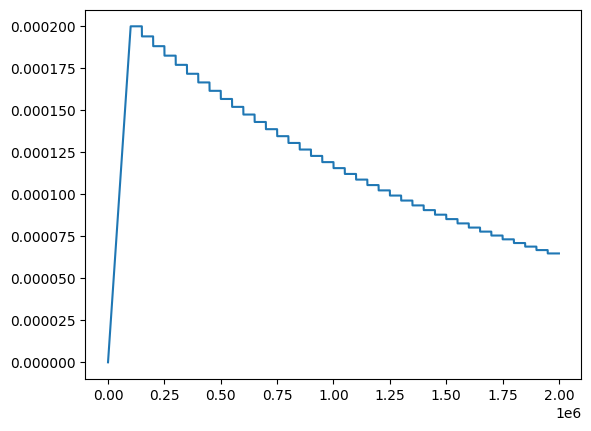

In [22]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(np.array(glr))